In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import random
from collections import deque
from tqdm import tqdm  
import pandas as pd
import copy

In [2]:
P_0_matrix=np.array([[0.005,0.793,0.202],
                   [0.027,0.558,0.415],
                   [0.736,0.249,0.015]])

P_0_matrix


array([[0.005, 0.793, 0.202],
       [0.027, 0.558, 0.415],
       [0.736, 0.249, 0.015]])

In [3]:
P_1_matrix=np.array([[0.718,0.254,0.028],
                   [0.347,0.097,0.556],
                   [0.015,0.956,0.029]])
P_1_matrix

array([[0.718, 0.254, 0.028],
       [0.347, 0.097, 0.556],
       [0.015, 0.956, 0.029]])

In [4]:
action_space=[0,1]
state_space=[0,1,2]
reward_matrix=[[0,0.699],[0,0.362],[0,0.715]]
N=100
M=20
epsilon=0.1
subsidy=0
# arm_indexes=[i for i in range(N)]
gamma=0.999
prob=0.2

In [5]:
def step(state,state_space,action,P_0_matrix,P_1_matrix,reward_matrix):
  new_state=state
  if(action==1):
    new_state=np.random.choice(state_space,replace=True,p=P_1_matrix[state])
    reward=reward_matrix[state][1]
  else:
    new_state=np.random.choice(state_space,replace=True,p=P_0_matrix[state])
    reward=reward_matrix[state][0]
  return [new_state,reward]

In [6]:
Q=copy.deepcopy(reward_matrix)

In [7]:


def act(Q_values,epsilon,state):
  decision=np.random.binomial(n=1,p=epsilon,size=1)
  if decision==1:
    action=random.choice([0,1])
  else:
    action=np.argmax(Q_values[state])
  return action

In [8]:
alternative_indexes=[0 for _ in range(N)]
current_state=random.choice([0,1,2])
nu=np.zeros((len(state_space),len(action_space)))


In [9]:
rewards=[]
subsidies=[]
action_avgs=[]
betas=[]
alphas=[]
epsilon=0.1

In [10]:
def alpha(i):
    return 1/(1+(i/10000))

In [11]:
reward_sum=0
action_sum=0
for i in range(1,100000001):
    # top_M_indices=act(alternative_indexes,N,M,epsilon)
    # alpha=1/(1+(i/500))
    beta=1/(1+(i*np.log(i)/10000))
    action_sum_flag=0


    action=act(Q,epsilon,current_state)
    action_sum+=action


    x=step(current_state,state_space,action,P_0_matrix,P_1_matrix,reward_matrix)
    new_state=x[0]
    reward=x[1]

    if action==1:
        Q[current_state][action]=(1-alpha(nu[current_state,action]))*(Q[current_state][action])+alpha(nu[current_state,action])*(reward+max(Q[new_state])-(np.array(Q).sum())/10)
    else:
        Q[current_state][action]=(1-alpha(nu[current_state,action]))*(Q[current_state][action])+alpha(nu[current_state,action])*(reward+subsidy+max(Q[new_state])-(np.array(Q).sum())/10)
    nu[current_state,action]=nu[current_state,action]+1
    current_state=new_state
    reward_sum+=reward
        
        #print(x)
    # print(i)
    #print(reward_sum)

    subsidy+=beta*(action_sum/i-prob)
    subsidies.append(subsidy)
    # epsilon=epsilon*gamma
    # if epsilon<=0.01:
    #     epsilon=0.01
    rewards.append(reward_sum/i)
    action_avgs.append(action_sum/i)
    betas.append(beta)

KeyboardInterrupt: 

In [ ]:
nu.sum()

100000000.0

Text(0.5, 1.0, 'Subsidy vs Steps for Restart Example')

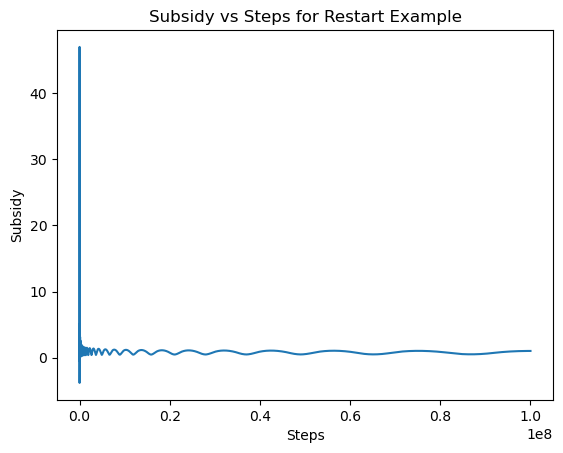

In [13]:
plt.plot(subsidies)
plt.xlabel('Steps')
plt.ylabel('Subsidy')
plt.title('Subsidy vs Steps for Non Whittle Indexable Example')

In [14]:
df=pd.DataFrame(rewards)


Text(0.5, 1.0, ' Moving Average of reward for Restart Example ')

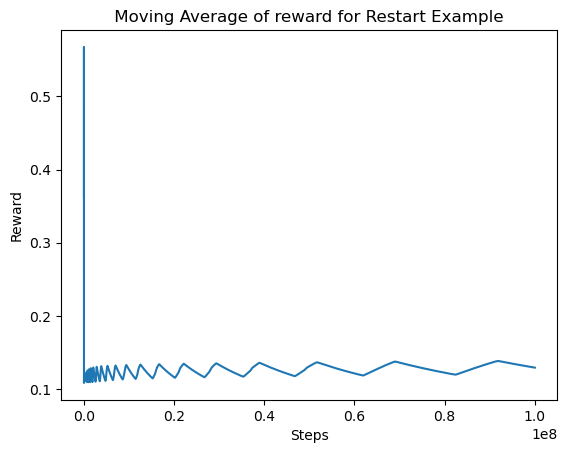

In [15]:
plt.plot(df[0].rolling(100000,min_periods=1).mean())
plt.xlabel('Steps')
plt.ylabel('Reward')
plt.title(' Moving Average of reward for Non Whittle Indexable Example ')


Text(0.5, 1.0, ' Moving Average of number of arms activated for Restart Example ')

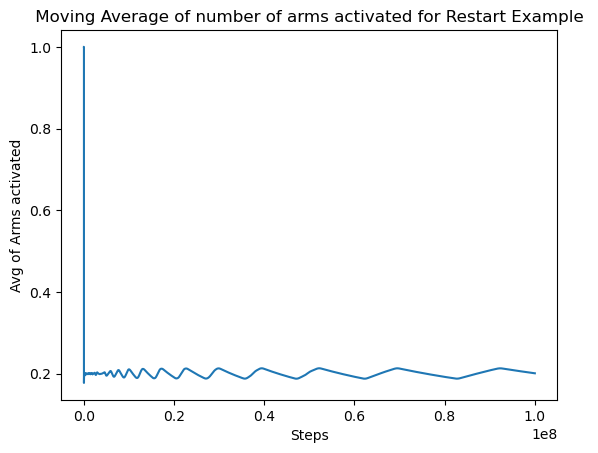

In [18]:
df['action_sums']=action_avgs
plt.plot(df['action_sums'].rolling(100000,min_periods=1).mean())
plt.xlabel('Steps')
plt.ylabel('Avg of Arms activated')
plt.title(' Moving Average of number of arms activated for Restart Example ')


In [19]:
arm_indexes=[i for i in range(N)]


In [20]:
#using learnt indices
current_state=[0 for _ in range(N)]
reward_sums_alt_index=[]
alternative_indexes=[0 for _ in range(N)]
for i in range(1,10001):
  reward_sum_alt_index=0
  reward_sum_whittle_index=0
  for index in arm_indexes:
    alternative_indexes[index]=Q[current_state[index]][1]-Q[current_state[index]][0]
  indices_to_pull = sorted(range(len(alternative_indexes)), key = lambda j: alternative_indexes[j])[-M:]
  for index in arm_indexes:
    if index in indices_to_pull:
      x=step(current_state[index],state_space,1,P_0_matrix,P_1_matrix,reward_matrix)
      new_state=x[0]
      reward=x[1]
      current_state[index]=new_state
      reward_sum_alt_index+=reward
    else:
      x=step(current_state[index],state_space,0,P_0_matrix,P_1_matrix,reward_matrix)
      new_state=x[0]
      reward=x[1]
      current_state[index]=new_state
      reward_sum_alt_index+=reward
  reward_sums_alt_index.append(reward_sum_alt_index)


In [21]:
whittle_index_arms=[0 for _ in range(N)]
current_state=[0 for _ in range(N)]
reward_sums_whittle_index=[]
actual_whittle_indexes=[0.6941985627000107, 0.5085415824511699, 0.41540222368454144]

for i in range(1,10001):
  reward_sum_whittle_index=0
  for index in arm_indexes:
    whittle_index_arms[index]=actual_whittle_indexes[current_state[index]]
  #print(whittle_index_arms)
  indices_to_pull = sorted(range(len(whittle_index_arms)), key = lambda j: whittle_index_arms[j])[-M:]
  # print(indices_to_pull)
  for index in arm_indexes:
    if index in indices_to_pull:
      x=step(current_state[index],state_space,1,P_0_matrix,P_1_matrix,reward_matrix)
      new_state=x[0]
      reward=x[1]
      current_state[index]=new_state
      reward_sum_whittle_index+=reward
    else:
      x=step(current_state[index],state_space,0,P_0_matrix,P_1_matrix,reward_matrix)
      new_state=x[0]
      reward=x[1]
      current_state[index]=new_state
      reward_sum_whittle_index+=reward
  reward_sums_whittle_index.append(reward_sum_whittle_index)

Text(0.5, 1.0, ' Moving Average of reward for Non Whittle Indexable Example ')

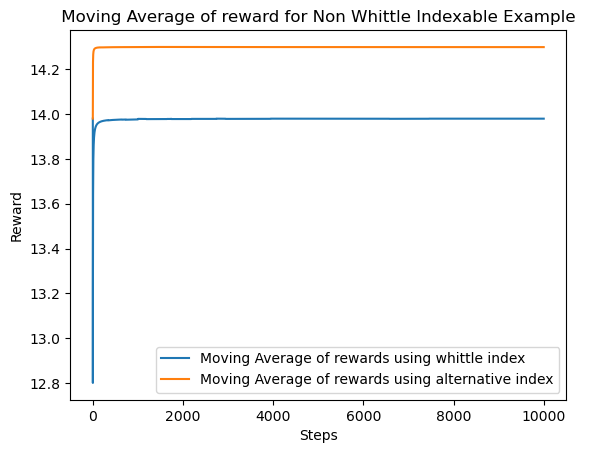

: 

In [22]:
df=pd.DataFrame()
df['reward_whittle']=reward_sums_whittle_index
df['reward_alternate']=reward_sums_alt_index

plt.plot(df['reward_whittle'][:50000].rolling(1000,min_periods=1).mean(),label='Moving Average of rewards using whittle index')
plt.plot(df['reward_alternate'][:50000].rolling(1000,min_periods=1).mean(),label='Moving Average of rewards using alternative index')
plt.xlabel('Steps')
plt.ylabel('Reward')
plt.legend()
plt.title(' Moving Average of reward for Non Whittle Indexable Example ')